<h3> Projekt 1<br>
Widzenie komputerowe<br>
Jakub Kondys, 151839<br>
Kacper Dąbrowski, 151521 </h3>

## Importy oraz wczytanie obrazów

In [110]:
import os
from numpy.typing import NDArray
from typing import List, Any
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [111]:
path = "family"
clear_img = [cv2.imread(os.path.join(path,image), cv2.IMREAD_COLOR_RGB) for image in os.listdir(path) if image.endswith(".JPG")]

## Funkcje pomocnicze

In [112]:
def imshow(a):
  display(Image.fromarray(a))

In [ ]:
def convertion(img_list, cvt_type, idx):
    if cvt_type == "None":
        return img_list
    cvt_binary = [cv2.COLOR_BGR2GRAY, cv2.COLOR_RGB2GRAY, cv2.COLOR_RGBA2GRAY, cv2.COLOR_BGRA2GRAY]
    if cvt_type in cvt_binary:
        return [cv2.cvtColor(img, cvt_type) for img in img_list]
    return [cv2.cvtColor(img, cvt_type)[:,:,idx] for img in img_list]

In [114]:
def union(img_list: List[NDArray], threshold = 0, convert = "None", idx = 0):
    images = convertion(img_list, convert, idx)
    min_array = np.min(images, axis=0)
    max_array = np.max(images, axis=0)
    return np.array((max_array - min_array <= threshold), dtype=np.uint8)*255

## Analiza problemu
Zadanie dotyczy złożenia 5 zdjęć rodzinnych w jeden obraz wynikowy. Należy tak przetworzyć obrazy, aby wszyscy członkowie rodziny mieli odwrócone twarze w stronę kamery i byli dobrze widoczni. Wynik przetwarzania powinien wyglądać następująco:

<center><div>
<img src="family/result.png" width="400"/>
</div></center>

Wszystkie obrazy są tej samej wielkości oraz są odpowiednio wykadrowane, więc w rezultacie wszystkie zdjęcia różnią się jedynie ruchami osób.

<center><div>
<img src="family/small_DSC_0168.JPG" width="500"/>
<img src="family/small_DSC_0170.JPG" width="500"/>
<img src="family/small_DSC_0173.JPG" width="500"/>
<img src="family/small_DSC_0174.JPG" width="500"/>
<img src="family/small_DSC_0176.JPG" width="500"/>
</div></center>


Do rozwiązania tego problemu należało dobrać odpowiedni sposób "pocięcia" fotografi w taki sposób, aby odseparować interesujące nas elementy zdjęć. Wg załączonej dokumentacji podane tam obszary wyglądały następująco:

<center><div>
<img src="family/Zrzut%20ekranu%20z%202025-04-19%2015-56-58.png" width="400"/>
</div></center>

## Testy

In [108]:
k = 7
s = 10
img = [cv2.GaussianBlur(cv2.imread(os.path.join(path,image), cv2.IMREAD_COLOR_RGB), (k,k), s) for image in os.listdir(path) if image.endswith(".JPG")]

In [10]:
img_gray = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in img]

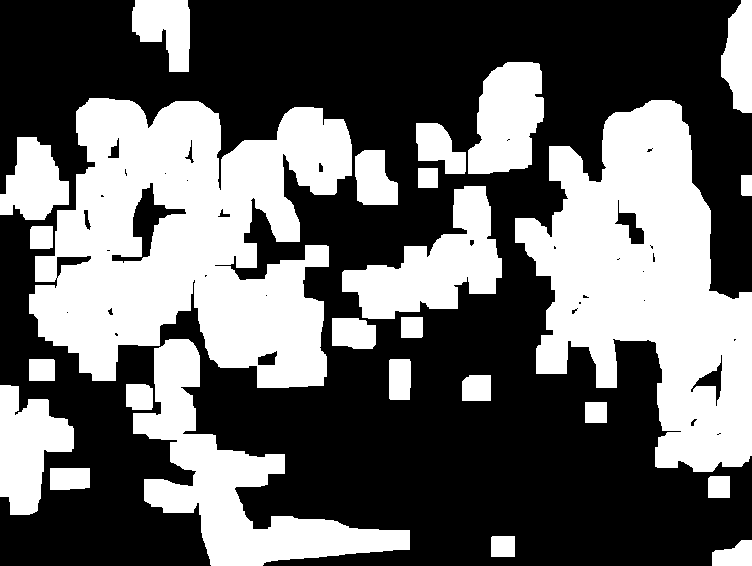

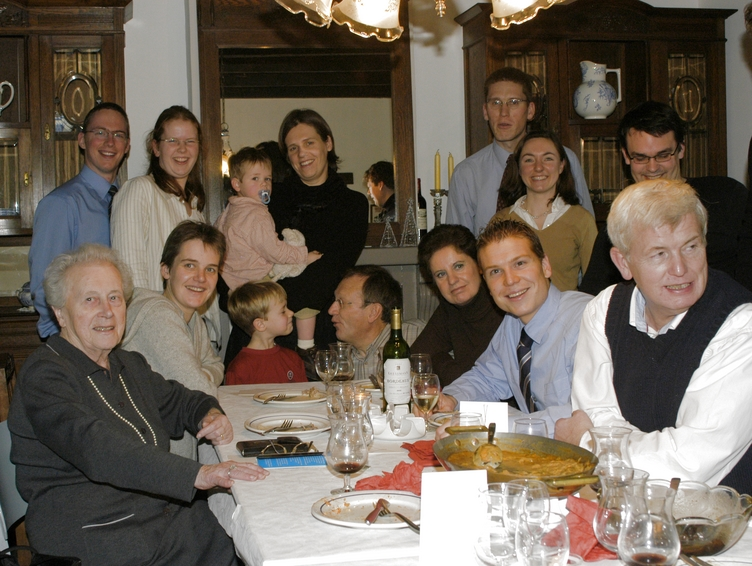

In [115]:
difference_img = union(img,convert=cv2.COLOR_RGB2HSV, idx=2, threshold = 10)
k = 20
new = cv2.morphologyEx((np.bitwise_not(difference_img)), cv2.MORPH_OPEN, np.ones((k,k)))
imshow(new)

imshow(clear_img[0])

In [98]:
difference_img = np.bitwise_not(new)

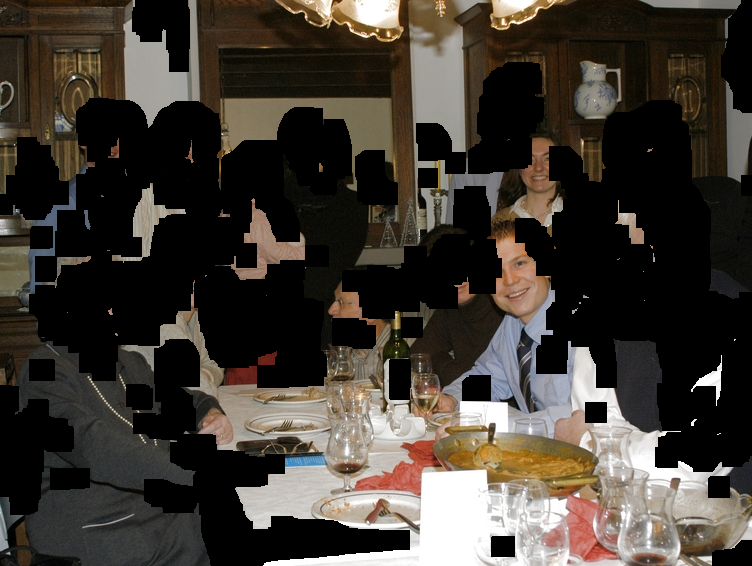

In [99]:
result = np.zeros(img[0].shape, dtype=np.uint8)
result[:,:,0] = difference_img/255*clear_img[0][:,:,0]
result[:,:,1] = difference_img/255*clear_img[0][:,:,1]
result[:,:,2] = difference_img/255*clear_img[0][:,:,2]
imshow(result)

In [53]:
def area_split(img):
    arr = []
    for x in np.arange(img.shape[0]):
        for y in np.arange(img.shape[1]):
            if img[x,y]:
                arr.append((x, y))
    return np.floor(np.mean(np.array(arr),axis=0)).astype(int)

In [15]:
print(area_split(np.bitwise_not(difference_img)))

[296 363]


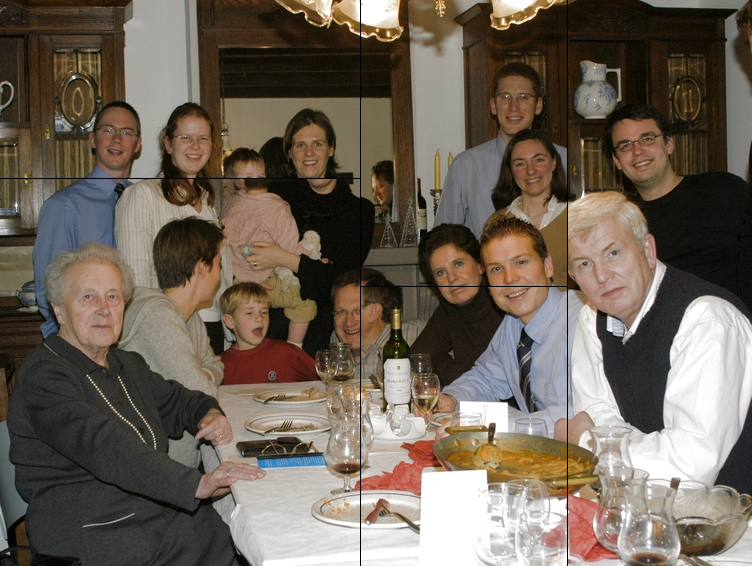

In [116]:
x1, y1 = area_split(np.bitwise_not(difference_img))
x2, y2 = area_split(np.bitwise_not(difference_img[0:x1,0:y1]))
x3, y3 = area_split(np.bitwise_not(difference_img[:,y1:-1]))
x4, y4 = area_split(np.bitwise_not(difference_img[:,y1:y1+y3]))
result = np.zeros(img[0].shape, dtype=np.uint8)
result[0:x2-1,0:y1-1,:] = clear_img[2][0:x2-1,0:y1-1,:]
result[x2:,0:y1-1,:] = clear_img[3][x2:,0:y1-1,:]
result[:x4-1,y1:y1+y3,:] = clear_img[1][:x4-1,y1:y1+y3,:] # baba chłop baba chłop
result[:,y1+y3+1:,:] = clear_img[4][:,y1+y3+1:,:] # dwa dziady na prawo
result[x4:,y1:y1+y3,:] = clear_img[0][x4:,y1:y1+y3,:]
"""
for u in np.arange(result.shape[0]):
    for v in np.arange(result.shape[1]):
        if not new[u,v]:
            result[u,v] = clear_img[0][u,v]
            """
imshow(result)

In [101]:
def gaussian_split(img):
    arr = []
    for x in np.arange(img.shape[0]):
        for y in np.arange(img.shape[1]):
            if img[x,y]:
                arr.append((x, y))
    x, y = np.floor(np.mean(np.array(arr),axis=0)).astype(int)
    stdx, stdy = np.floor(3*np.std(np.array(arr),axis=0)).astype(int)
    return np.clip(x-stdx, 0, img.shape[0]) , np.clip(x+stdx, 0, img.shape[0]) ,np.clip(y-stdy, 0, img.shape[1]) ,np.clip(y+stdy, 0, img.shape[1]) 

In [102]:
x, y = area_split(np.bitwise_not(difference_img))
a,b,c,d = gaussian_split(np.bitwise_not(difference_img)[:x,:y])
e,f,g,h = gaussian_split(np.bitwise_not(difference_img)[x:,:y])
i,j,k,l = gaussian_split(np.bitwise_not(difference_img)[x:,y:])
m,n,o,p = gaussian_split(np.bitwise_not(difference_img)[:x,y:])

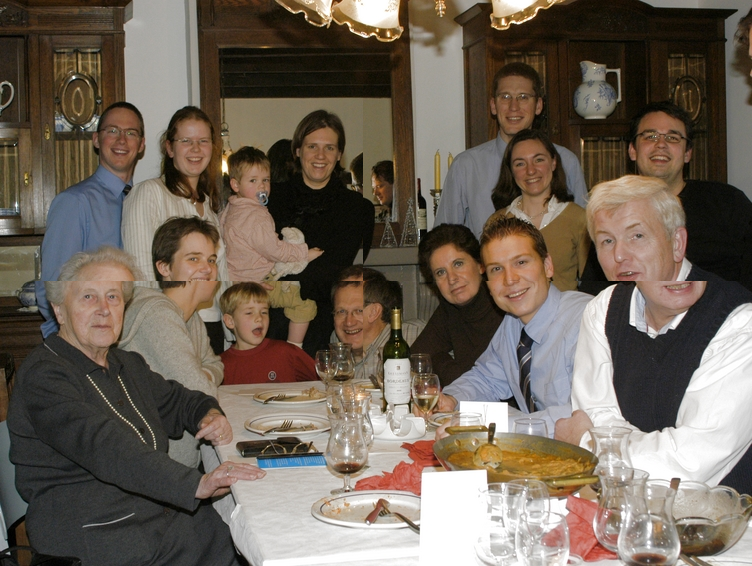

In [103]:
result = np.zeros(img[0].shape, dtype=np.uint8)
result[a:b,c:d] = clear_img[4][a:b,c:d]
result[e+x:f+x,g:h] = clear_img[3][e+x:f+x,g:h]
result[i+x:j+x,k+y:l+y] = clear_img[0][i+x:j+x,k+y:l+y]
result[m:n,o+y:p+y] = clear_img[1][m:n,o+y:p+y]
imshow(result)

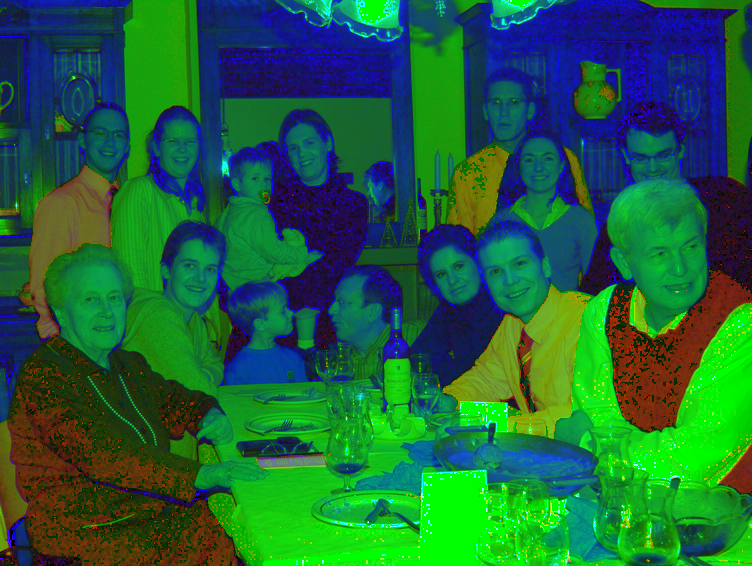

In [31]:
imshow(cv2.cvtColor(clear_img[0], cv2.COLOR_RGB2HLS))

In [ ]:
imshow(clear)